In [1]:
import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier

In [15]:
!pip install imblearn

# Data Loading and Preprocessing


In [2]:
#Read the dataset - Amazon fine food reviews
data = pd.read_csv("Reviews.csv")
#check the info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data.drop(['Id', 'Summary', 'ProfileName', 'HelpfulnessDenominator', 'HelpfulnessNumerator', 'Time', 'UserId', 'ProductId'], axis=1)
data.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [5]:
data.isna().any()

Score    False
Text     False
dtype: bool

In [6]:
score = data['Score'].values 
score1 = []
for a in score:
    if a>3:
        a=1
    elif a<3:
        a=0
    else:
        a=float('NaN')
    score1.append(a)
data['Score'] = score1

data = data.dropna()

In [7]:
data.head()

,Score,Text
0,1.0,I have bought several of the Vitality canned d...
1,0.0,Product arrived labeled as Jumbo Salted Peanut...
2,1.0,This is a confection that has been around a fe...
3,0.0,If you are looking for the secret ingredient i...
4,1.0,Great taffy at a great price. There was a wid...


In [8]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def text_preprocess(text):
    text = text.lower() #converts to lower alphabets 
    #removing HTML tags
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, '', text)
    
    #decontract words ex: 'haven't' -> 'have not' etc
    text = decontracted(text)
    
    #removing digits
    for word in text:
        if word.isdigit():
            text = text.replace(word, ' ')
    
    #removing words of length higher or equal to 15
    
    text = re.sub(r'\b\w{15,}', '', text)
    return text

text = data['Text'].values

for i in range(len(text)):
    text[i] = text_preprocess(text[i])
    
data['Text'] = text

data.head()

,Score,Text
0,1.0,i have bought several of the vitality canned d...
1,0.0,product arrived labeled as jumbo salted peanut...
2,1.0,this is a confection that has been around a fe...
3,0.0,if you are looking for the secret ingredient i...
4,1.0,great taffy at a great price. there was a wid...


In [9]:
y = data['Score'].values
x = data.drop(['Score'], axis=1)

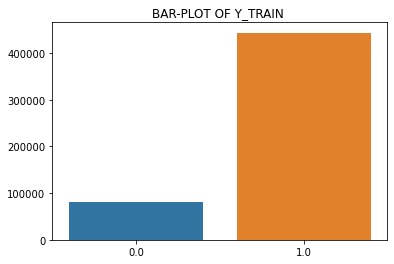

In [10]:
unique, counts = np.unique(y, return_counts=True)
sns.barplot(x=unique, y=counts)
plt.title('BAR-PLOT OF Y_TRAIN ')
plt.show()

In [11]:
#train_cv split:

from sklearn.model_selection import train_test_split

x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.33, stratify=y)

In [12]:
print(x_train.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)


(352295, 1) (352295,)
(173519, 1) (173519,)


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf vectorizer
vect = TfidfVectorizer(min_df=15, max_features = 10000)
x_tfidf_tr = vect.fit_transform(x_train['Text'].values)
x_tfidf_cv = vect.transform(x_cv['Text'].values)


print(x_tfidf_tr.shape)
print(x_tfidf_cv.shape)

(352295, 10000)
(173519, 10000)


In [45]:
pickle.dump(vect, open('vectorizer.pkl','wb'))

In [16]:
#Up Sampling the data since there are very few cases for class 0
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state = 7) 
x_os_tr, y_train = sm.fit_sample(x_tfidf_tr, y_train) 



In [17]:
print(x_os_tr.shape,y_train.shape)

(594660, 10000) (594660,)


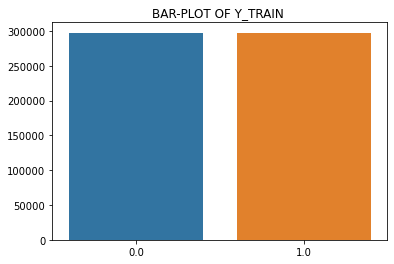

In [18]:
unique, counts = np.unique(y_train, return_counts=True)
sns.barplot(x=unique, y=counts)
plt.title('BAR-PLOT OF Y_TRAIN ')
plt.show()

# Logistic Regression

In [19]:
#using logistic regression classifier
from sklearn.linear_model import SGDClassifier



clf = SGDClassifier(loss='log')
param = {'alpha' : [0.0001, 0.001, 0.01, 1, 10, 100]}
tuner = GridSearchCV(clf, param, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
tuner.fit(x_os_tr, y_train)

results = pd.DataFrame.from_dict(tuner.cv_results_)

results = results.sort_values(['param_alpha'])
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,76.885266,28.523683,1.985382,2.406527,0.0001,{'alpha': 0.0001},0.948944,0.959911,0.959475,0.960252,...,0.957787,0.004432,1,0.960173,0.958066,0.958153,0.958040,0.957944,0.958475,0.000851
1,65.533040,46.118724,2.866267,0.721241,0.001,{'alpha': 0.001},0.912913,0.927894,0.927639,0.928503,...,0.925029,0.006065,2,0.927150,0.924802,0.925276,0.925259,0.924752,0.925448,0.000879
2,14.692428,4.695624,2.633118,0.493610,0.01,{'alpha': 0.01},0.884308,0.902298,0.902663,0.903459,...,0.898925,0.007327,3,0.900680,0.898728,0.899694,0.899772,0.897537,0.899282,0.001069
3,24.040359,1.542601,1.523982,0.993373,1,{'alpha': 1},0.871987,0.886988,0.894392,0.890827,...,0.886532,0.007691,4,0.889681,0.882990,0.891115,0.886677,0.883667,0.886826,0.003202
4,17.091057,1.007008,0.380297,0.182367,10,{'alpha': 10},0.867046,0.889240,0.890751,0.891787,...,0.886169,0.009611,5,0.885426,0.885318,0.887255,0.887688,0.887338,0.886605,0.001018
5,12.718653,2.692408,0.194852,0.186057,100,{'alpha': 100},0.868141,0.889892,0.890660,0.889918,...,0.885845,0.008858,6,0.886370,0.885992,0.887159,0.885726,0.885881,0.886226,0.000513


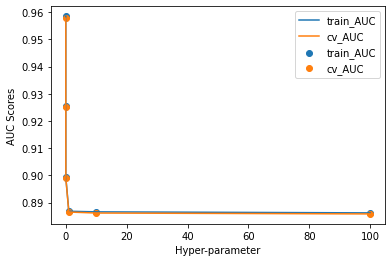

In [20]:
train_auc = results['mean_train_score']
cv_auc = results['mean_test_score']
alpha = results['param_alpha']

plt.plot(alpha, train_auc, label="train_AUC" )
plt.plot(alpha, cv_auc, label='cv_AUC')
plt.scatter(alpha, train_auc, label="train_AUC")
plt.scatter(alpha, cv_auc, label='cv_AUC')

plt.legend()
plt.xlabel('Hyper-parameter')
plt.ylabel('AUC Scores')
plt.show()

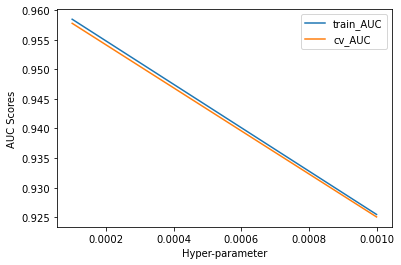

In [21]:
plt.plot(alpha[:2], train_auc[:2], label="train_AUC" )
plt.plot(alpha[:2], cv_auc[:2], label='cv_AUC')

plt.legend()
plt.xlabel('Hyper-parameter')
plt.ylabel('AUC Scores')
plt.show()

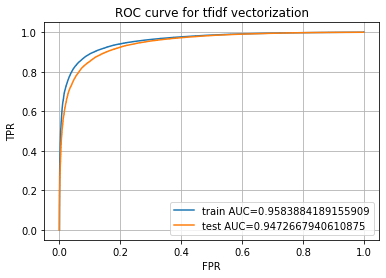

In [22]:
#Training Logistic Regression model with alpha=0.0001

clf = SGDClassifier(loss='log', alpha=0.0001)
clf.fit(x_os_tr, y_train)

train_pred = clf.predict_proba(x_os_tr)[:,1]
test_pred = clf.predict_proba(x_tfidf_cv)[:,1]

tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train, train_pred)
te_fpr, te_tpr, te_threshold = roc_curve(y_cv, test_pred)

plt.plot(tr_fpr, tr_tpr, label="train AUC="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr, te_tpr, label="test AUC="+str(auc(te_fpr, te_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for tfidf vectorization") 

plt.grid()
plt.show()


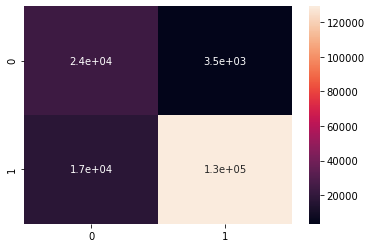

In [23]:
#test data confusion matrix
sns.heatmap(confusion_matrix(y_cv, clf.predict(x_tfidf_cv)), annot= True)
plt.show()

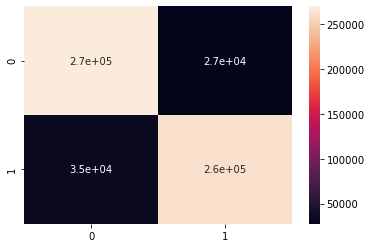

In [24]:
#train_data confusion matrix

sns.heatmap(confusion_matrix(y_train, clf.predict(x_os_tr)), annot= True)
plt.show()

In [25]:
#calculating F1 Score

y_predte = clf.predict(x_tfidf_cv)
f1_test = f1_score(y_cv, y_predte)



print('F1 score for test set', f1_test)

F1 score for test set 0.9253508809656932


# Decision Tree:

In [ ]:
#Decision Tree 

from sklearn import tree
from tqdm import tqdm


clf = tree.DecisionTreeClassifier(class_weight='balanced')
param = {'max_depth':  [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
tuner = GridSearchCV(clf, param, cv=3, scoring='roc_auc', return_train_score=True)
tuner.fit(x_os_tr, y_train)

results = pd.DataFrame.from_dict(tuner.cv_results_)


In [ ]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,7.237812,0.258317,0.455213,0.027233,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.652164,0.692226,0.691555,0.678648,0.018729,13,0.691890,0.671862,0.672198,0.678650,0.009363
1,8.643983,0.136418,0.486689,0.024761,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.652164,0.692226,0.691555,0.678648,0.018729,13,0.691890,0.671862,0.672198,0.678650,0.009363
2,8.749293,0.298232,0.487178,0.029494,1,100,"{'max_depth': 1, 'min_samples_split': 100}",0.652164,0.692226,0.691555,0.678648,0.018729,13,0.691890,0.671862,0.672198,0.678650,0.009363
3,8.814527,0.232779,0.493045,0.023608,1,500,"{'max_depth': 1, 'min_samples_split': 500}",0.652164,0.692226,0.691555,0.678648,0.018729,13,0.691890,0.671862,0.672198,0.678650,0.009363
4,39.038671,2.457260,0.494099,0.025373,5,5,"{'max_depth': 5, 'min_samples_split': 5}",0.770598,0.830653,0.831555,0.810935,0.028525,9,0.835497,0.804394,0.805618,0.815170,0.014382
5,37.247578,2.273855,0.486014,0.038770,5,10,"{'max_depth': 5, 'min_samples_split': 10}",0.770598,0.830614,0.831555,0.810923,0.028516,10,0.835497,0.804394,0.805618,0.815170,0.014382
6,33.304301,2.551445,0.466099,0.030358,5,100,"{'max_depth': 5, 'min_samples_split': 100}",0.770553,0.830627,0.831543,0.810908,0.028538,11,0.835462,0.804324,0.805567,0.815118,0.014395
7,29.818681,2.352680,0.462788,0.023636,5,500,"{'max_depth': 5, 'min_samples_split': 500}",0.770389,0.830521,0.831461,0.810790,0.028571,12,0.835254,0.804212,0.805338,0.814935,0.014375
8,80.143559,3.748202,0.481881,0.024228,10,5,"{'max_depth': 10, 'min_samples_split': 5}",0.823323,0.880771,0.881132,0.861742,0.027167,5,0.889790,0.863183,0.863727,0.872233,0.012416
9,79.830350,3.454783,0.468364,0.018652,10,10,"{'max_depth': 10, 'min_samples_split': 10}",0.823241,0.880680,0.881248,0.861723,0.027212,6,0.889719,0.863086,0.863685,0.872163,0.012416


In [ ]:
result = results.groupby(['param_max_depth', 'param_min_samples_split']).max().unstack()[['mean_test_score', 'mean_train_score']]
print(result)

                        mean_test_score            ... mean_train_score          
param_min_samples_split             5         10   ...              100       500
param_max_depth                                    ...                           
1                              0.678648  0.678648  ...         0.678650  0.678650
5                              0.810935  0.810923  ...         0.815118  0.814935
10                             0.861742  0.861723  ...         0.870636  0.867760
50                             0.890667  0.897290  ...         0.981651  0.962203

[4 rows x 8 columns]


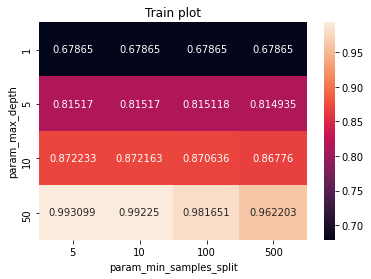

In [ ]:
sns.heatmap(result.mean_train_score, annot=True, fmt='.6g')
plt.title('Train plot')
plt.show()

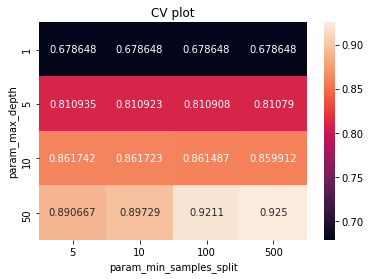

In [ ]:
sns.heatmap(result.mean_test_score, annot=True, fmt='.6g')
plt.title('CV plot')
plt.show()

*Therefore the best hyper-parameters are max-depth = 50 and min_sample_split=500.*

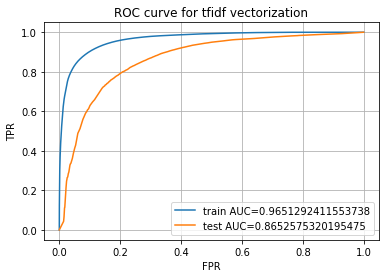

In [ ]:
clf = tree.DecisionTreeClassifier( max_depth = 50, min_samples_split=500, criterion='gini',class_weight='balanced')
clf.fit(x_os_tr, y_train)

train_pred = clf.predict_proba(x_os_tr)[:,1]
test_pred = clf.predict_proba(x_tfidf_cv)[:,1]

tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train, train_pred)
te_fpr, te_tpr, te_threshold = roc_curve(y_cv, test_pred)

plt.plot(tr_fpr, tr_tpr, label="train AUC="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr, te_tpr, label="test AUC="+str(auc(te_fpr, te_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for tfidf vectorization") 

plt.grid()
plt.show()

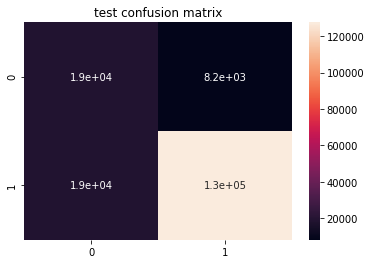

In [ ]:
sns.heatmap(confusion_matrix(y_cv, clf.predict(x_tfidf_cv)), annot= True)
plt.title('test confusion matrix')
plt.show()

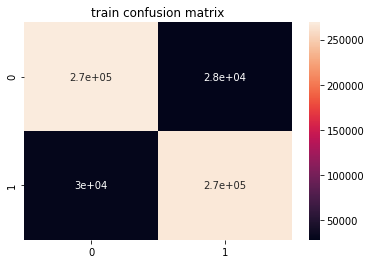

In [ ]:
sns.heatmap(confusion_matrix(y_train, clf.predict(x_os_tr)), annot= True)
plt.title('train confusion matrix')
plt.show()

In [ ]:
#calculating F1 Score

y_predte = clf.predict(x_tfidf_cv)
f1_test = f1_score(y_cv, y_predte)


print('F1 score for test set', f1_test)

*Decision Tree is worse than Logistic Regression model here.*

# Naive Bayes Model

In [26]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(class_prior = [0.5, 0.5])

param = {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1,10,100]}


tuner = GridSearchCV(clf, param, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
tuner.fit(x_os_tr, y_train)

results = pd.DataFrame.from_dict(tuner.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.830501,7.295964,0.318661,0.046885,1e-05,{'alpha': 1e-05},0.948569,0.958433,0.957957,0.958260,...,0.956451,0.003957,2,0.959848,0.957266,0.957466,0.957259,0.957199,0.957808,0.001024
1,11.483733,7.855122,0.221122,0.093038,0.0001,{'alpha': 0.0001},0.948550,0.958412,0.957934,0.958250,...,0.956431,0.003956,3,0.959828,0.957247,0.957446,0.957242,0.957179,0.957788,0.001024
2,16.473790,2.236414,0.226162,0.128358,0.001,{'alpha': 0.001},0.948528,0.958385,0.957906,0.958237,...,0.956407,0.003954,4,0.959804,0.957223,0.957422,0.957218,0.957154,0.957764,0.001024
3,11.450737,0.835603,0.360057,0.037134,0.01,{'alpha': 0.01},0.948503,0.958353,0.957873,0.958220,...,0.956377,0.003952,6,0.959773,0.957192,0.957392,0.957188,0.957123,0.957734,0.001024
4,5.524276,4.328826,0.340478,0.152961,0.1,{'alpha': 0.1},0.948494,0.958317,0.957839,0.958204,...,0.956351,0.003943,7,0.959736,0.957158,0.957357,0.957150,0.957089,0.957698,0.001023
5,1.872792,0.170908,0.254718,0.082445,1,{'alpha': 1},0.948678,0.958308,0.957844,0.958244,...,0.956397,0.003874,5,0.959702,0.957145,0.957344,0.957123,0.957076,0.957678,0.001016
6,2.368702,0.363131,0.311732,0.092938,10,{'alpha': 10},0.949266,0.958198,0.957852,0.958303,...,0.956509,0.003638,1,0.959468,0.957009,0.957205,0.956942,0.956927,0.957510,0.000984
7,2.065215,0.257129,0.319345,0.141727,100,{'alpha': 100},0.947022,0.955590,0.955529,0.956043,...,0.954165,0.003593,8,0.956657,0.954321,0.954472,0.954177,0.954175,0.954760,0.000955


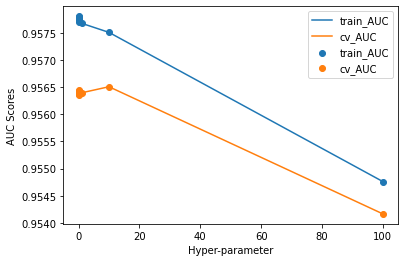

In [27]:
train_auc = results['mean_train_score']
cv_auc = results['mean_test_score']
alpha = results['param_alpha']

plt.plot(alpha, train_auc, label="train_AUC" )
plt.plot(alpha, cv_auc, label='cv_AUC')
plt.scatter(alpha, train_auc, label="train_AUC")
plt.scatter(alpha, cv_auc, label='cv_AUC')

plt.legend()
plt.xlabel('Hyper-parameter')
plt.ylabel('AUC Scores')
plt.show()

**Therefore the best auc for alpha=10.**

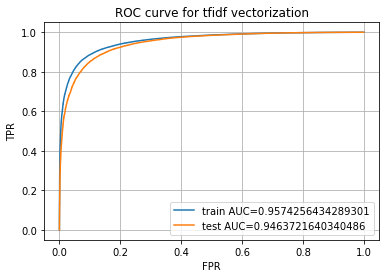

In [28]:
clf = MultinomialNB(alpha=10, class_prior = [0.5, 0.5])
clf.fit(x_os_tr, y_train)

train_pred = clf.predict_proba(x_os_tr)[:,1]
test_pred = clf.predict_proba(x_tfidf_cv)[:,1]

tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train, train_pred)
te_fpr, te_tpr, te_threshold = roc_curve(y_cv, test_pred)

plt.plot(tr_fpr, tr_tpr, label="train AUC="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr, te_tpr, label="test AUC="+str(auc(te_fpr, te_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for tfidf vectorization") 

plt.grid()
plt.show()


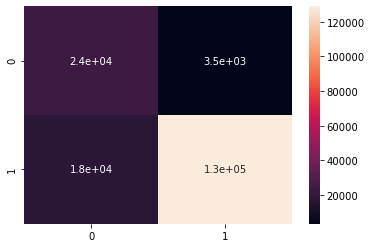

In [29]:
#test data confusion matrix
sns.heatmap(confusion_matrix(y_cv, clf.predict(x_tfidf_cv)), annot= True)
plt.show()

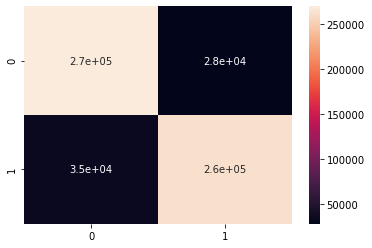

In [30]:
#train_data confusion matrix

sns.heatmap(confusion_matrix(y_train, clf.predict(x_os_tr)), annot= True)
plt.show()

In [31]:
#calculating F1 Score

y_predte = clf.predict(x_tfidf_cv)
f1_test = f1_score(y_cv, y_predte)


print('F1 score for test set', f1_test)

F1 score for test set 0.924332605037796


# Stacking the logistic Regression Model and the Naive bayes model with a logistic regression model over it.

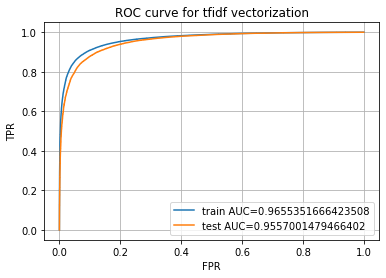

In [39]:
estimators = [('NB' , MultinomialNB(alpha=10, class_prior = [0.5, 0.5])) , ('logisticreg', SGDClassifier(loss='log', alpha=0.0001))]

clf = StackingClassifier(estimators=estimators, final_estimator=SGDClassifier(loss='log'))

clf.fit(x_os_tr, y_train)

train_pred = clf.predict_proba(x_os_tr)[:,1]
test_pred = clf.predict_proba(x_tfidf_cv)[:,1]

tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train, train_pred)
te_fpr, te_tpr, te_threshold = roc_curve(y_cv, test_pred)

plt.plot(tr_fpr, tr_tpr, label="train AUC="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr, te_tpr, label="test AUC="+str(auc(te_fpr, te_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for tfidf vectorization") 

plt.grid()
plt.show()

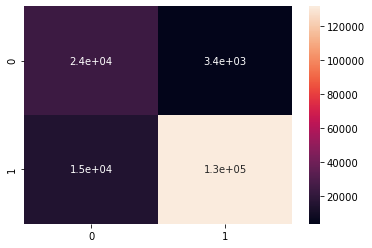

In [40]:
#test data confusion matrix
sns.heatmap(confusion_matrix(y_cv, clf.predict(x_tfidf_cv)), annot= True)
plt.show()

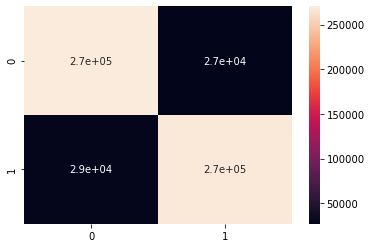

In [41]:
#train data confusion matrix
sns.heatmap(confusion_matrix(y_train, clf.predict(x_os_tr)), annot= True)
plt.show()

In [42]:
#calculating F1 Score

y_predte = clf.predict(x_tfidf_cv)
f1_test = f1_score(y_cv, y_predte)


print('F1 score for test set', f1_test)

F1 score for test set 0.9360614355555081


In [43]:
from prettytable import PrettyTable

table = PrettyTable()


table.field_names = ['Model', 'Test AUC', 'Test F1-score']

table.add_row(['Logistic Regression',0.9473 , 0.9254])
table.add_row(['Decision Tree', 0.8653, 0.84])
table.add_row(['Multinomial Naive bayes', 0.9464, 0.9243])
table.add_row(['Stacking Classifier', 0.9563 ,0.9378])
print(table)

+-------------------------+----------+---------------+
|          Model          | Test AUC | Test F1-score |
+-------------------------+----------+---------------+
|   Logistic Regression   |  0.9473  |     0.9254    |
|      Decision Tree      |  0.8653  |      0.84     |
| Multinomial Naive bayes |  0.9464  |     0.9243    |
|   Stacking Classifier   |  0.9563  |     0.9378    |
+-------------------------+----------+---------------+


In [44]:
pickle.dump(clf, open('model.pkl','wb'))

# Building Deep Neural Network over the bert pooled outputs

In [ ]:
##create an NN and 
input_layer = Input(shape=(768,))
layer_1 = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(30))(input_layer)
layer_2 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(30))(layer_1)
drop = Dropout(0.6)(layer_2)
layer_3 = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(30))(drop)
layer_4 = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(30))(layer_3)
batchnorm = BatchNormalization()(layer_4)
drop = Dropout(0.6)(batchnorm)
layer_5 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(30))(drop)
output = Dense(2,activation='softmax',kernel_initializer=tf.keras.initializers.HeUniform(30))(layer_5) 

model = Model(inputs=input_layer,outputs=output)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)              

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils import to_categorical

y_tr = to_categorical(y_train)
y_te = to_categorical(y_test)



print(y_tr.shape)
print(y_te.shape)

(80000, 2)
(20000, 2)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.AUC()])

logdir = os.path.join("/content/gdrive/My Drive/bert/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)



call = [tensorboard_callback]


In [ ]:
model.fit(X_train_pooled_output, y_tr, epochs= 40, batch_size=256, verbose=1,callbacks=call, validation_data=(X_test_pooled_output,y_te))

Epoch 1/40
  1/313 [..............................] - ETA: 0s - loss: 0.5854 - auc: 0.8991WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


  2/313 [..............................] - ETA: 15s - loss: 0.6395 - auc: 0.8875WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0106s vs `on_train_batch_end` time: 0.0901s). Check your callbacks.


313/313 [==============================] - 2s 7ms/step - loss: 0.4470 - auc: 0.8716 - val_loss: 0.4465 - val_auc: 0.8502
Epoch 2/40
313/313 [==============================] - 2s 6ms/step - loss: 0.3640 - auc: 0.9090 - val_loss: 1.7750 - val_auc: 0.2241
Epoch 3/40
313/313 [==============================] - 2s 6ms/step - loss: 0.2216 - auc: 0.9703 - val_loss: 0.7057 - val_auc: 0.5055
Epoch 4/40
313/313 [==============================] - 2s 6ms/step - loss: 0.2017 - auc: 0.9754 - val_loss: 0.3452 - val_auc: 0.9432
Epoch 5/40
313/313 [==============================] - 2s 6ms/step - loss: 0.1944 - auc: 0.9770 - val_loss: 0.3406 - val_auc: 0.9334
Epoch 6/40
313/313 [==============================] - 2s 6ms/step - loss: 0.1898 - auc: 0.9780 - val_loss: 0.6406 - val_auc: 0.7418
Epoch 7/40
313/313 [==============================] - 2s 6ms/step - loss: 0.1842 - auc: 0.9793 - val_loss: 0.4335 - val_auc: 0.8791
Epoch 8/40
313/313 [==============================] - 2s 6ms/step - loss: 0.1811 - auc:

In [ ]:
model.save('/content/gdrive/My Drive/bert/model.h5')

# Review Analysing section

In [ ]:
 def analyze_review(review):

  cleanr = re.compile('<.*?>')
  sen = re.sub(cleanr, '', review)
  sen = sen.lower()

  max_len=55

  x_tee=[]
  msk_te=[]
  tokens = tokenizer.tokenize(sen)

  if len(tokens)>=(max_len-2):
    tokens = tokens[:(max_len-2)]

      
  tokens = ['[CLS]',*tokens, '[SEP]']
  length = len(tokens)
  tok = [1]*length


  if length <max_len:
    tokens.extend(['[PAD]']*(max_len-length))
    tok.extend([0]*(max_len-length))
    
  tokens = np.array(tokenizer.convert_tokens_to_ids(tokens))
  x_tee.append(tokens)
  msk_te.append(tok)


  X_test_tokens = np.array(x_tee)

  X_test_mask = np.array(msk_te)


  X_test_segment = ([0]*max_len)
  X_test_segment = np.array(X_test_segment)

  X_test_segment = X_test_segment.reshape(1,-1)
  return X_test_tokens, X_test_mask, X_test_segment


In [ ]:
def classify_review(X_test_tokens,X_test_mask,X_test_segment):
  X_test = bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

  y_hat = model.predict(X_test)

  class_label = np.argmax(y_hat[0])
 
  if class_label == 0:
    print('the review is NEGATIVE')
  else:
    print('the review is POSITIVE')
  print('the probability scores are: ', y_hat[0][0], y_hat[0][1])

In [ ]:
review = input("Enter the review: ")

x,y,z = analyze_review(review)

classify_review(x,y,z)

Enter the review: good job
the review is POSITIVE
the probability scores are:  0.17416328 0.8258367


In [ ]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import tensorflow_hub as hub
import numpy as np
from tensorflow import keras
import re


In [ ]:
input_layer = Input(shape=(768,))
layer_1 = Dense(512, activation='relu', kernel_initializer=keras.initializers.HeUniform(30))(input_layer)
layer_2 = Dense(256, activation='relu', kernel_initializer=keras.initializers.HeUniform(30))(layer_1)
drop = Dropout(0.6)(layer_2)
layer_3 = Dense(128, activation='relu', kernel_initializer=keras.initializers.HeUniform(30))(drop)
layer_4 = Dense(128, activation='relu', kernel_initializer=keras.initializers.HeUniform(30))(layer_3)
batchnorm = BatchNormalization()(layer_4)
drop = Dropout(0.6)(batchnorm)
layer_5 = Dense(64, activation='relu', kernel_initializer=keras.initializers.HeUniform(30))(drop)
output = Dense(2,activation='softmax',kernel_initializer=keras.initializers.HeUniform(30))(layer_5) 

model = Model(inputs=input_layer,outputs=output)